Phase 1 Results:
Viable strategies: ['qEI', 'qGIBBON', 'qUCB']
Eliminated: {'Random'}

Phase 2 Results:
Robust strategies: []
Degradation scores: {}


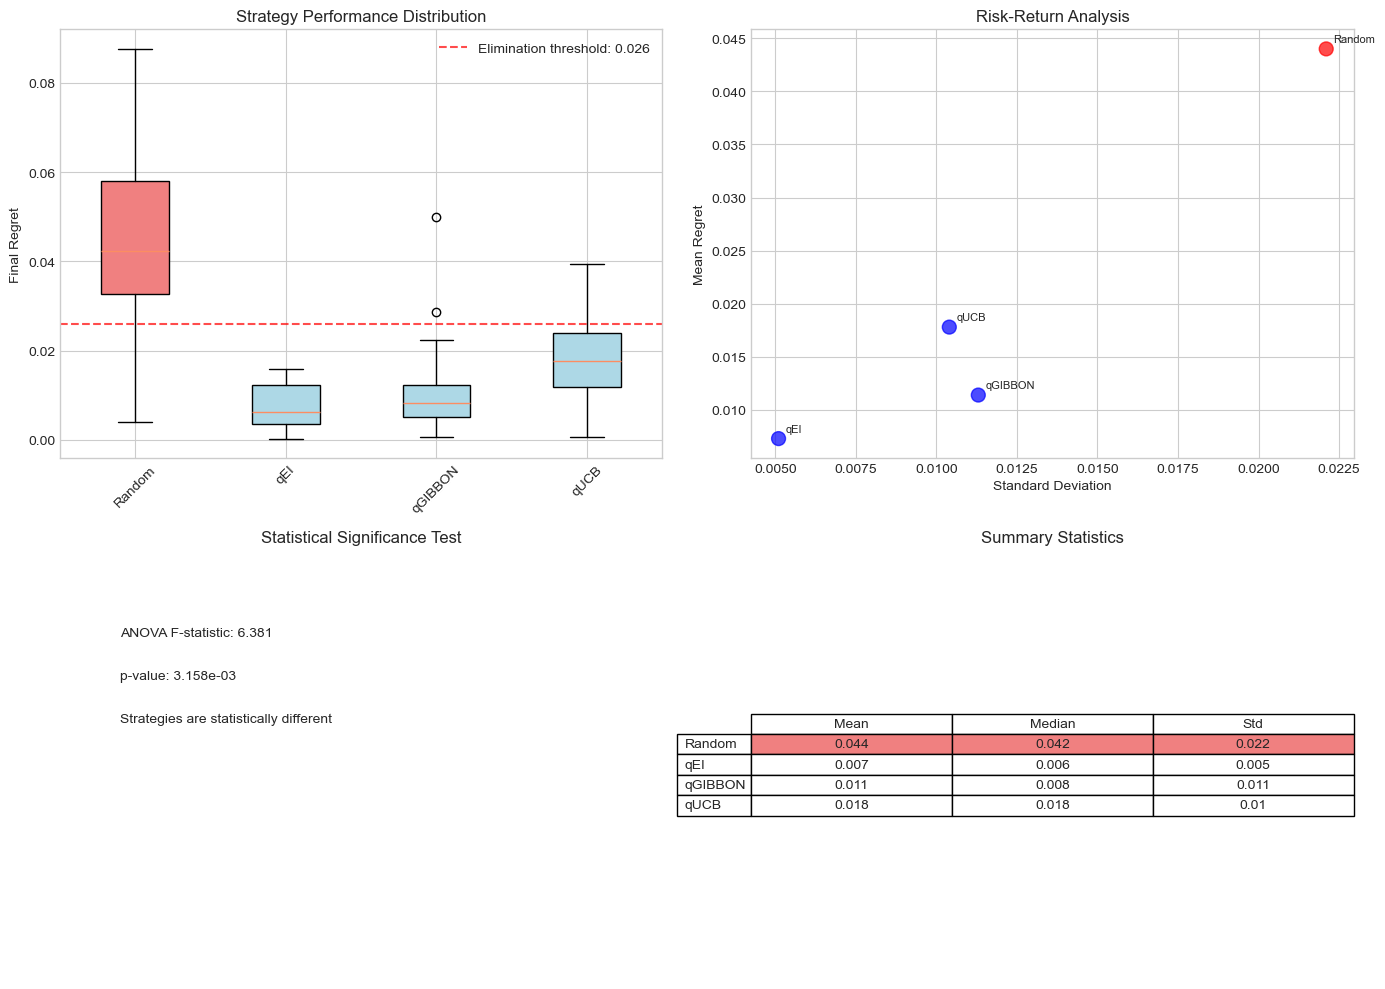

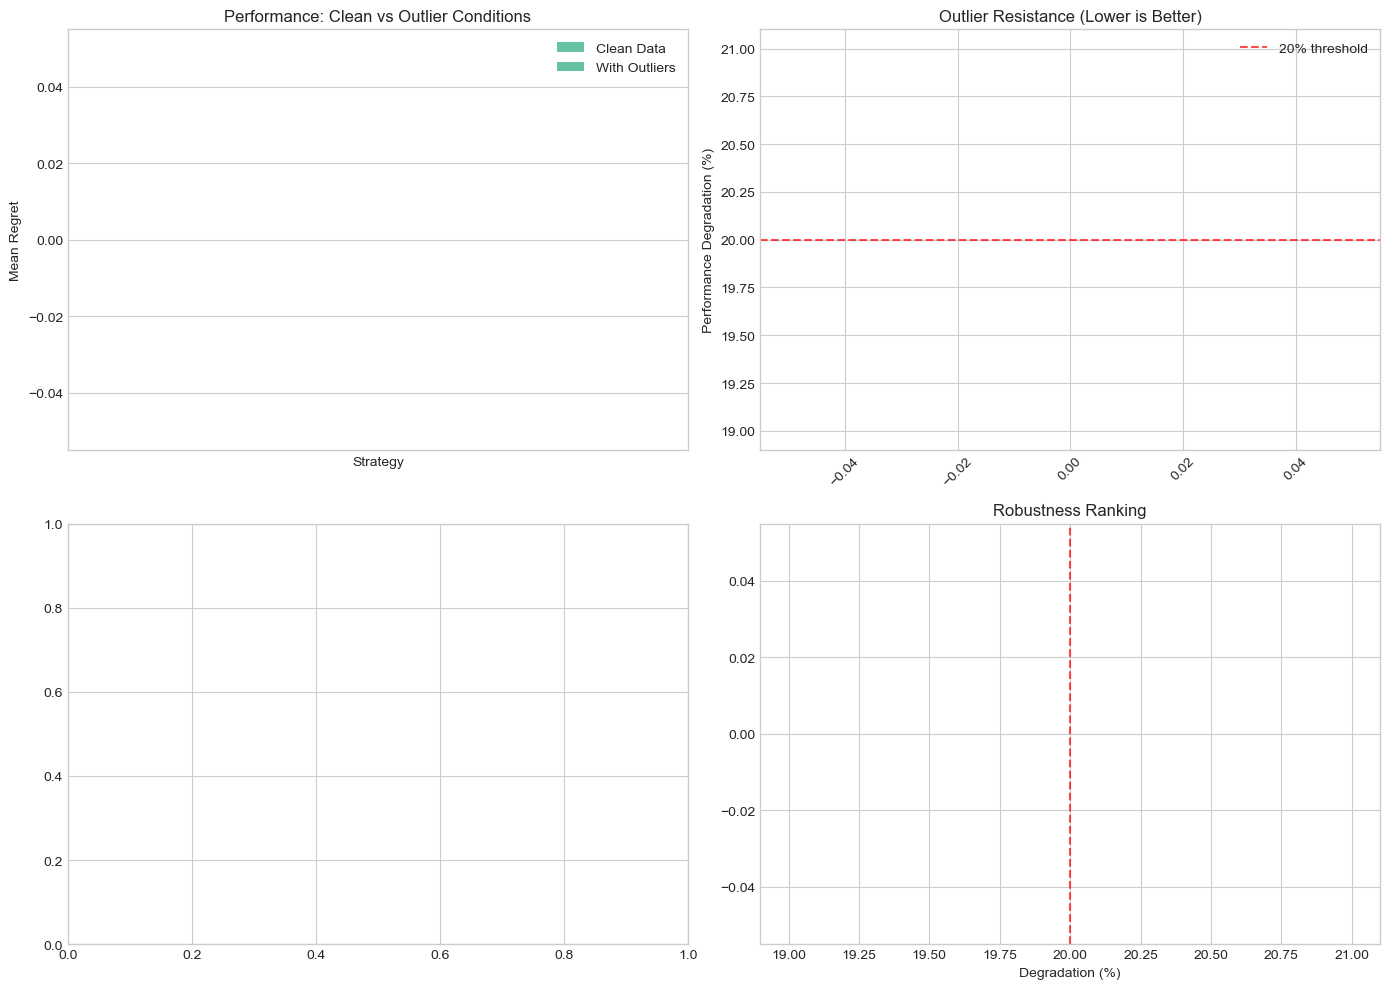

['iteration', 'acquisition_type', 'ground_truth_method', 'use_transfer_learning', 'prior_strength', 'outliers_enabled', 'outlier_fraction', 'outlier_type', 'outlier_magnitude', 'mse', 'rmse_h', 'r2', 'crps', 'coverage_high_region', 'posterior_mean', 'true_best', 'observed_best', 'true_value_at_best_observed', 'true_value_at_model_optimum', 'regret', 'exploitative_regret', 'CI_size_avg', 'coverage_95', 'seed', 'num_init', 'batch_size', 'noise_level', 'noise_strategy', 'gt_config']


In [17]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set scientific plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

def load_and_clean_data(filename):
    """Load CSV with proper column cleaning"""
    df = pd.read_csv(filename, sep=';')
    df.columns = [col.strip().strip('"') for col in df.columns]
    return df

def phase1_elimination_analysis(df):
    """Phase 1: Statistical elimination of poor strategies"""
    
    # Get final regret per run
    final_regrets = df.groupby(['acquisition_type', 'seed'])['regret'].last().reset_index()
    
    # Statistical analysis
    strategy_stats = final_regrets.groupby('acquisition_type')['regret'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(4)
    
    # Elimination criteria
    median_threshold = strategy_stats['median'].median() * 2
    viable_strategies = strategy_stats[strategy_stats['median'] <= median_threshold].index
    
    return final_regrets, strategy_stats, viable_strategies

def create_elimination_plots(final_regrets, strategy_stats, viable_strategies):
    """Create publication-quality elimination plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Boxplot with elimination threshold
    ax1 = axes[0, 0]
    box_data = [final_regrets[final_regrets['acquisition_type'] == strategy]['regret'].values 
                for strategy in strategy_stats.index]
    
    bp = ax1.boxplot(box_data, labels=strategy_stats.index, patch_artist=True)
    
    # Color viable vs eliminated
    for i, strategy in enumerate(strategy_stats.index):
        if strategy in viable_strategies:
            bp['boxes'][i].set_facecolor('lightblue')
        else:
            bp['boxes'][i].set_facecolor('lightcoral')
    
    threshold = strategy_stats['median'].median() * 2
    ax1.axhline(y=threshold, color='red', linestyle='--', alpha=0.7, label=f'Elimination threshold: {threshold:.3f}')
    ax1.set_ylabel('Final Regret')
    ax1.set_title('Strategy Performance Distribution')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Mean vs Std scatter
    ax2 = axes[0, 1]
    colors = ['blue' if s in viable_strategies else 'red' for s in strategy_stats.index]
    scatter = ax2.scatter(strategy_stats['std'], strategy_stats['mean'], 
                         c=colors, alpha=0.7, s=100)
    
    for i, strategy in enumerate(strategy_stats.index):
        ax2.annotate(strategy, (strategy_stats['std'].iloc[i], strategy_stats['mean'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_xlabel('Standard Deviation')
    ax2.set_ylabel('Mean Regret')
    ax2.set_title('Risk-Return Analysis')
    
    # Plot 3: Statistical significance test
    ax3 = axes[1, 0]
    
    # ANOVA test between strategies
    strategy_groups = [final_regrets[final_regrets['acquisition_type'] == s]['regret'].values 
                      for s in viable_strategies]
    
    if len(strategy_groups) > 1:
        f_stat, p_value = stats.f_oneway(*strategy_groups)
        ax3.text(0.1, 0.8, f'ANOVA F-statistic: {f_stat:.3f}', transform=ax3.transAxes)
        ax3.text(0.1, 0.7, f'p-value: {p_value:.3e}', transform=ax3.transAxes)
        ax3.text(0.1, 0.6, 'Strategies are statistically different' if p_value < 0.05 else 'No significant difference', 
                transform=ax3.transAxes)
    
    ax3.set_title('Statistical Significance Test')
    ax3.axis('off')
    
    # Plot 4: Summary statistics table
    ax4 = axes[1, 1]
    table_data = strategy_stats[['mean', 'median', 'std']].round(3)
    table = ax4.table(cellText=table_data.values,
                     rowLabels=table_data.index,
                     colLabels=['Mean', 'Median', 'Std'],
                     cellLoc='center',
                     loc='center')
    
    # Color table rows
    for i, strategy in enumerate(table_data.index):
        if strategy not in viable_strategies:
            for j in range(len(table_data.columns)):
                table[(i+1, j)].set_facecolor('lightcoral')
    
    ax4.set_title('Summary Statistics')
    ax4.axis('off')
    
    plt.tight_layout()
    return fig

def phase2_outlier_analysis(df, viable_strategies):
    """Phase 2: Outlier resistance analysis"""
    
    df_viable = df[df['acquisition_type'].isin(viable_strategies)]
    
    # Performance with and without outliers
    outlier_comparison = df_viable.groupby(['acquisition_type', 'outliers_enabled'])['regret'].agg([
        'mean', 'median', 'std'
    ]).round(4)
    
    # Calculate degradation scores
    degradation_scores = {}
    
    for strategy in viable_strategies:
        clean_data = df_viable[(df_viable['acquisition_type'] == strategy) & 
                              (df_viable['outliers_enabled'] == False)]
        outlier_data = df_viable[(df_viable['acquisition_type'] == strategy) & 
                                (df_viable['outliers_enabled'] == True)]
        
        if len(clean_data) > 0 and len(outlier_data) > 0:
            clean_mean = clean_data['regret'].mean()
            outlier_mean = outlier_data['regret'].mean()
            degradation = (outlier_mean - clean_mean) / clean_mean if clean_mean > 0 else np.inf
            degradation_scores[strategy] = degradation
    
    # Filter robust strategies (< 20% degradation)
    robust_strategies = [s for s, deg in degradation_scores.items() if deg < 0.2]
    
    return outlier_comparison, degradation_scores, robust_strategies

def create_outlier_plots(df_viable, degradation_scores, robust_strategies):
    """Create outlier resistance plots"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Before/After outlier comparison
    ax1 = axes[0, 0]
    
    strategies = list(degradation_scores.keys())
    clean_means = []
    outlier_means = []
    
    for strategy in strategies:
        clean_mean = df_viable[(df_viable['acquisition_type'] == strategy) & 
                              (df_viable['outliers_enabled'] == False)]['regret'].mean()
        outlier_mean = df_viable[(df_viable['acquisition_type'] == strategy) & 
                                (df_viable['outliers_enabled'] == True)]['regret'].mean()
        clean_means.append(clean_mean)
        outlier_means.append(outlier_mean)
    
    x = np.arange(len(strategies))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, clean_means, width, label='Clean Data', alpha=0.8)
    bars2 = ax1.bar(x + width/2, outlier_means, width, label='With Outliers', alpha=0.8)
    
    ax1.set_xlabel('Strategy')
    ax1.set_ylabel('Mean Regret')
    ax1.set_title('Performance: Clean vs Outlier Conditions')
    ax1.set_xticks(x)
    ax1.set_xticklabels(strategies, rotation=45)
    ax1.legend()
    
    # Plot 2: Degradation scores
    ax2 = axes[0, 1]
    
    colors = ['green' if s in robust_strategies else 'red' for s in strategies]
    bars = ax2.bar(strategies, [degradation_scores[s] * 100 for s in strategies], 
                   color=colors, alpha=0.7)
    
    ax2.axhline(y=20, color='red', linestyle='--', alpha=0.7, label='20% threshold')
    ax2.set_ylabel('Performance Degradation (%)')
    ax2.set_title('Outlier Resistance (Lower is Better)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend()
    
    # Plot 3: Violin plots showing distribution changes
    ax3 = axes[1, 0]
    
    # Prepare data for violin plot
    plot_data = []
    plot_labels = []
    
    for strategy in strategies:
        clean_data = df_viable[(df_viable['acquisition_type'] == strategy) & 
                              (df_viable['outliers_enabled'] == False)]['regret'].values
        outlier_data = df_viable[(df_viable['acquisition_type'] == strategy) & 
                                (df_viable['outliers_enabled'] == True)]['regret'].values
        
        if len(clean_data) > 0:
            plot_data.append(clean_data)
            plot_labels.append(f'{strategy}_clean')
        if len(outlier_data) > 0:
            plot_data.append(outlier_data)
            plot_labels.append(f'{strategy}_outlier')
    
    if plot_data:
        violin_parts = ax3.violinplot(plot_data, positions=range(len(plot_data)))
        ax3.set_xticks(range(len(plot_data)))
        ax3.set_xticklabels(plot_labels, rotation=90)
        ax3.set_ylabel('Regret')
        ax3.set_title('Distribution Shape Changes')
    
    # Plot 4: Robustness ranking
    ax4 = axes[1, 1]
    
    sorted_strategies = sorted(degradation_scores.items(), key=lambda x: x[1])
    strategy_names = [s[0] for s in sorted_strategies]
    degradation_values = [s[1] * 100 for s in sorted_strategies]
    
    colors = ['green' if s[0] in robust_strategies else 'red' for s in sorted_strategies]
    
    bars = ax4.barh(strategy_names, degradation_values, color=colors, alpha=0.7)
    ax4.axvline(x=20, color='red', linestyle='--', alpha=0.7)
    ax4.set_xlabel('Degradation (%)')
    ax4.set_title('Robustness Ranking')
    
    plt.tight_layout()
    return fig

# Usage example:
def run_scientific_analysis(filename):
    """Run complete scientific analysis pipeline"""
    
    # Load data
    df = load_and_clean_data(filename)
    
    # Phase 1: Elimination
    final_regrets, strategy_stats, viable_strategies = phase1_elimination_analysis(df)
    fig1 = create_elimination_plots(final_regrets, strategy_stats, viable_strategies)
    
    print("Phase 1 Results:")
    print(f"Viable strategies: {list(viable_strategies)}")
    print(f"Eliminated: {set(strategy_stats.index) - set(viable_strategies)}")
    
    # Phase 2: Outlier analysis
    outlier_comparison, degradation_scores, robust_strategies = phase2_outlier_analysis(df, viable_strategies)
    fig2 = create_outlier_plots(df[df['acquisition_type'].isin(viable_strategies)], 
                                degradation_scores, robust_strategies)
    
    print("\nPhase 2 Results:")
    print(f"Robust strategies: {robust_strategies}")
    print("Degradation scores:", {k: f"{v:.1%}" for k, v in degradation_scores.items()})
    
    return fig1, fig2, robust_strategies

# Run analysis
fig1, fig2, final_strategies = run_scientific_analysis('bo_all_metrics_mc_standard.csv')
plt.show()
# print all columns of dataset
df = load_and_clean_data('bo_all_metrics_mc_standard.csv')
print(df.columns.tolist())


SyntaxError: invalid syntax (1126211428.py, line 1)

Loaded data: (7040, 29)
Available columns: ['iteration', 'acquisition_type', 'ground_truth_method', 'use_transfer_learning', 'prior_strength', 'outliers_enabled', 'outlier_fraction', 'outlier_type', 'outlier_magnitude', 'mse', 'rmse_h', 'r2', 'crps', 'coverage_high_region', 'posterior_mean', 'true_best', 'observed_best', 'true_value_at_best_observed', 'true_value_at_model_optimum', 'regret', 'exploitative_regret', 'CI_size_avg', 'coverage_95', 'seed', 'num_init', 'batch_size', 'noise_level', 'noise_strategy', 'gt_config']
Unique acquisition types: ['qUCB' 'qEI' 'Random' 'qGIBBON']
Unique num_init values: [ 5 10 20]
=== PHASE 1: INITIAL ELIMINATION ===

Baseline data: 6860 rows
Final regrets calculated for 240 runs
Unique strategies: 12

Elimination threshold: 0.0265 (2x global median: 0.0132)

📊 STRATEGY PERFORMANCE:
------------------------------------------------------------
qGIBBON_init5        | Median: 0.0069 ✅ | Runs: 20 ✅ | VIABLE
qEI_init20           | Median: 0.0071 ✅ | Runs: 

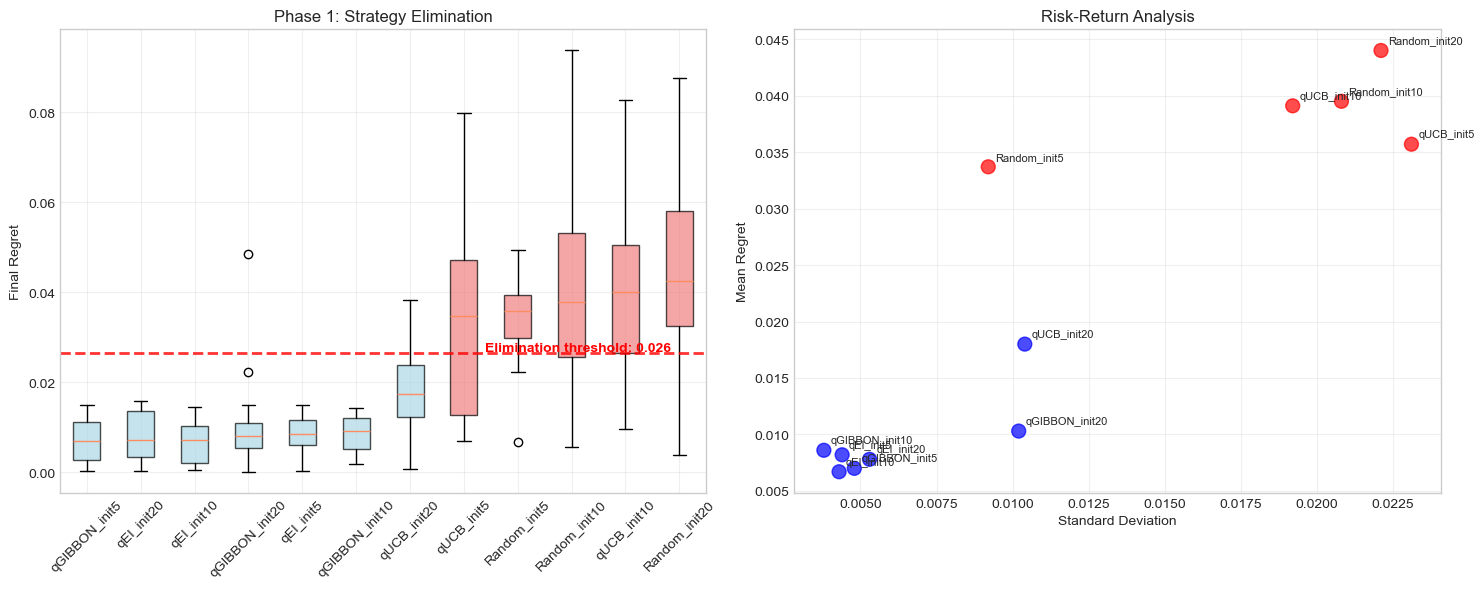


🏆 PHASE 1 COMPLETE
Surviving strategies: 8
Ready for Phase 2 analysis


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def phase1_elimination(df, elimination_threshold=2.0, min_success_rate=0.7):
   """
   Phase 1: Quick elimination of obviously poor strategies
   """
   
   print("=== PHASE 1: INITIAL ELIMINATION ===\n")
   
   # Filter to clean baseline conditions
   baseline_data = df[
       (df['outliers_enabled'] == False) & 
       (df['use_transfer_learning'] == False)
   ].copy()
   
   if len(baseline_data) == 0:
       print("No baseline data found. Using all data.")
       baseline_data = df.copy()
   
   print(f"Baseline data: {len(baseline_data)} rows")
   
   # Create strategy identifier
   baseline_data['strategy'] = baseline_data['acquisition_type'] + '_init' + baseline_data['num_init'].astype(str)
   
   # Get final regret per run (last iteration per seed/strategy)
   final_regrets = baseline_data.groupby(['strategy', 'seed'])['regret'].last().reset_index()
   
   print(f"Final regrets calculated for {len(final_regrets)} runs")
   print(f"Unique strategies: {final_regrets['strategy'].nunique()}")
   
   # Calculate strategy statistics
   strategy_stats = final_regrets.groupby('strategy')['regret'].agg([
       'count', 'mean', 'median', 'std', 'min', 'max'
   ]).round(4)
   
   strategy_stats.columns = ['n_runs', 'mean_regret', 'median_regret', 'std_regret', 'min_regret', 'max_regret']
   
   # Elimination criteria
   global_median = strategy_stats['median_regret'].median()
   threshold = global_median * elimination_threshold
   
   print(f"\nElimination threshold: {threshold:.4f} (2x global median: {global_median:.4f})")
   
   # Apply elimination criteria
   # 1. Performance criterion
   performance_viable = strategy_stats['median_regret'] <= threshold
   
   # 2. Success rate criterion (assume all converged if we have final regrets)
   success_rates = strategy_stats['n_runs'] / strategy_stats['n_runs'].max()
   success_viable = success_rates >= min_success_rate
   
   # Combined viability
   viable_strategies = strategy_stats[performance_viable & success_viable].index.tolist()
   eliminated_strategies = strategy_stats[~(performance_viable & success_viable)].index.tolist()
   
   # Results summary
   print(f"\n📊 STRATEGY PERFORMANCE:")
   print("-" * 60)
   for strategy in strategy_stats.sort_values('median_regret').index:
       perf_status = "✅" if performance_viable[strategy] else "❌"
       success_status = "✅" if success_viable[strategy] else "❌"
       overall_status = "VIABLE" if strategy in viable_strategies else "ELIMINATED"
       
       print(f"{strategy:20} | Median: {strategy_stats.loc[strategy, 'median_regret']:.4f} {perf_status} | "
             f"Runs: {strategy_stats.loc[strategy, 'n_runs']:2d} {success_status} | {overall_status}")
   
   print(f"\n🎯 ELIMINATION RESULTS:")
   print(f"Threshold: {threshold:.4f}")
   print(f"Viable strategies: {len(viable_strategies)}")
   print(f"Eliminated strategies: {len(eliminated_strategies)}")
   print(f"Viable: {viable_strategies}")
   print(f"Eliminated: {eliminated_strategies}")
   
   # Create elimination plot
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
   
   # Plot 1: Boxplot with threshold
   strategy_order = strategy_stats.sort_values('median_regret').index
   box_data = [final_regrets[final_regrets['strategy'] == s]['regret'].values for s in strategy_order]
   
   bp = ax1.boxplot(box_data, labels=strategy_order, patch_artist=True)
   
   # Color boxes
   for i, strategy in enumerate(strategy_order):
       if strategy in viable_strategies:
           bp['boxes'][i].set_facecolor('lightblue')
           bp['boxes'][i].set_alpha(0.7)
       else:
           bp['boxes'][i].set_facecolor('lightcoral')
           bp['boxes'][i].set_alpha(0.7)
   
   ax1.axhline(y=threshold, color='red', linestyle='--', alpha=0.8, linewidth=2)
   ax1.text(len(strategy_order) * 0.7, threshold * 1.02, f'Elimination threshold: {threshold:.3f}', 
            color='red', fontweight='bold')
   
   ax1.set_ylabel('Final Regret')
   ax1.set_title('Phase 1: Strategy Elimination')
   ax1.tick_params(axis='x', rotation=45)
   ax1.grid(True, alpha=0.3)
   
   # Plot 2: Performance summary
   colors = ['blue' if s in viable_strategies else 'red' for s in strategy_stats.index]
   
   ax2.scatter(strategy_stats['std_regret'], strategy_stats['mean_regret'], 
               c=colors, alpha=0.7, s=100)
   
   for strategy in strategy_stats.index:
       ax2.annotate(strategy, 
                   (strategy_stats.loc[strategy, 'std_regret'], 
                    strategy_stats.loc[strategy, 'mean_regret']),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
   
   ax2.set_xlabel('Standard Deviation')
   ax2.set_ylabel('Mean Regret')
   ax2.set_title('Risk-Return Analysis')
   ax2.grid(True, alpha=0.3)
   
   plt.tight_layout()
   plt.show()
   
   # Return results
   results = {
       'viable_strategies': viable_strategies,
       'eliminated_strategies': eliminated_strategies,
       'strategy_stats': strategy_stats,
       'final_regrets': final_regrets,
       'threshold': threshold,
       'elimination_plot': fig
   }
   
   return results

# Usage
def run_phase1_analysis(csv_file):
   """Run Phase 1 analysis from CSV file"""
   
   # Load data
   df = pd.read_csv(csv_file, sep=';')
   df.columns = [col.strip().strip('"') for col in df.columns]
   
   print(f"Loaded data: {df.shape}")
   print(f"Available columns: {list(df.columns)}")
   print(f"Unique acquisition types: {df['acquisition_type'].unique()}")
   print(f"Unique num_init values: {df['num_init'].unique()}")
   
   # Run Phase 1
   phase1_results = phase1_elimination(df)
   
   return phase1_results

# Execute
if __name__ == "__main__":
   phase1_results = run_phase1_analysis('bo_all_metrics_mc_standard.csv')
   
   print(f"\n🏆 PHASE 1 COMPLETE")
   print(f"Surviving strategies: {len(results['viable_strategies'])}")
   print(f"Ready for Phase 2 analysis")


=== PHASE 2: OPTIMAL ALLOCATION (FIXED BUDGET) ===

Fixed budget: 40 experiments per strategy
Goal: Find best initial/BO split for each acquisition function

Testing 7 allocation configurations:
  - qEI_init10
  - qEI_init20
  - qEI_init5
  - qGIBBON_init10
  - qGIBBON_init20
  - qGIBBON_init5
  - qUCB_init20

📊 ALLOCATION COMPARISON BY ACQUISITION FUNCTION:

🔍 qGIBBON Configurations:
--------------------------------------------------
  qGIBBON_init10     | Init: 10 (25.0%) | BO: 30 | Final Regret: 0.0084 ± 0.0043
  qGIBBON_init20     | Init: 20 (50.0%) | BO: 20 | Final Regret: 0.0114 ± 0.0113
  qGIBBON_init5      | Init:  5 (12.5%) | BO: 35 | Final Regret: 0.0067 ± 0.0048

  ✅ OPTIMAL: qGIBBON_init5
     └─ Performance: 0.0067
     └─ Allocation: 5 initial + 35 BO (12.5% exploration)
     └─ Improvement vs worst: 41.8%
     └─ Improvement vs average: 32.9%
  ❌ Suboptimal: qGIBBON_init10 (+26.2% worse)
  ❌ Suboptimal: qGIBBON_init20 (+71.7% worse)

🔍 qUCB Configurations:
--------------

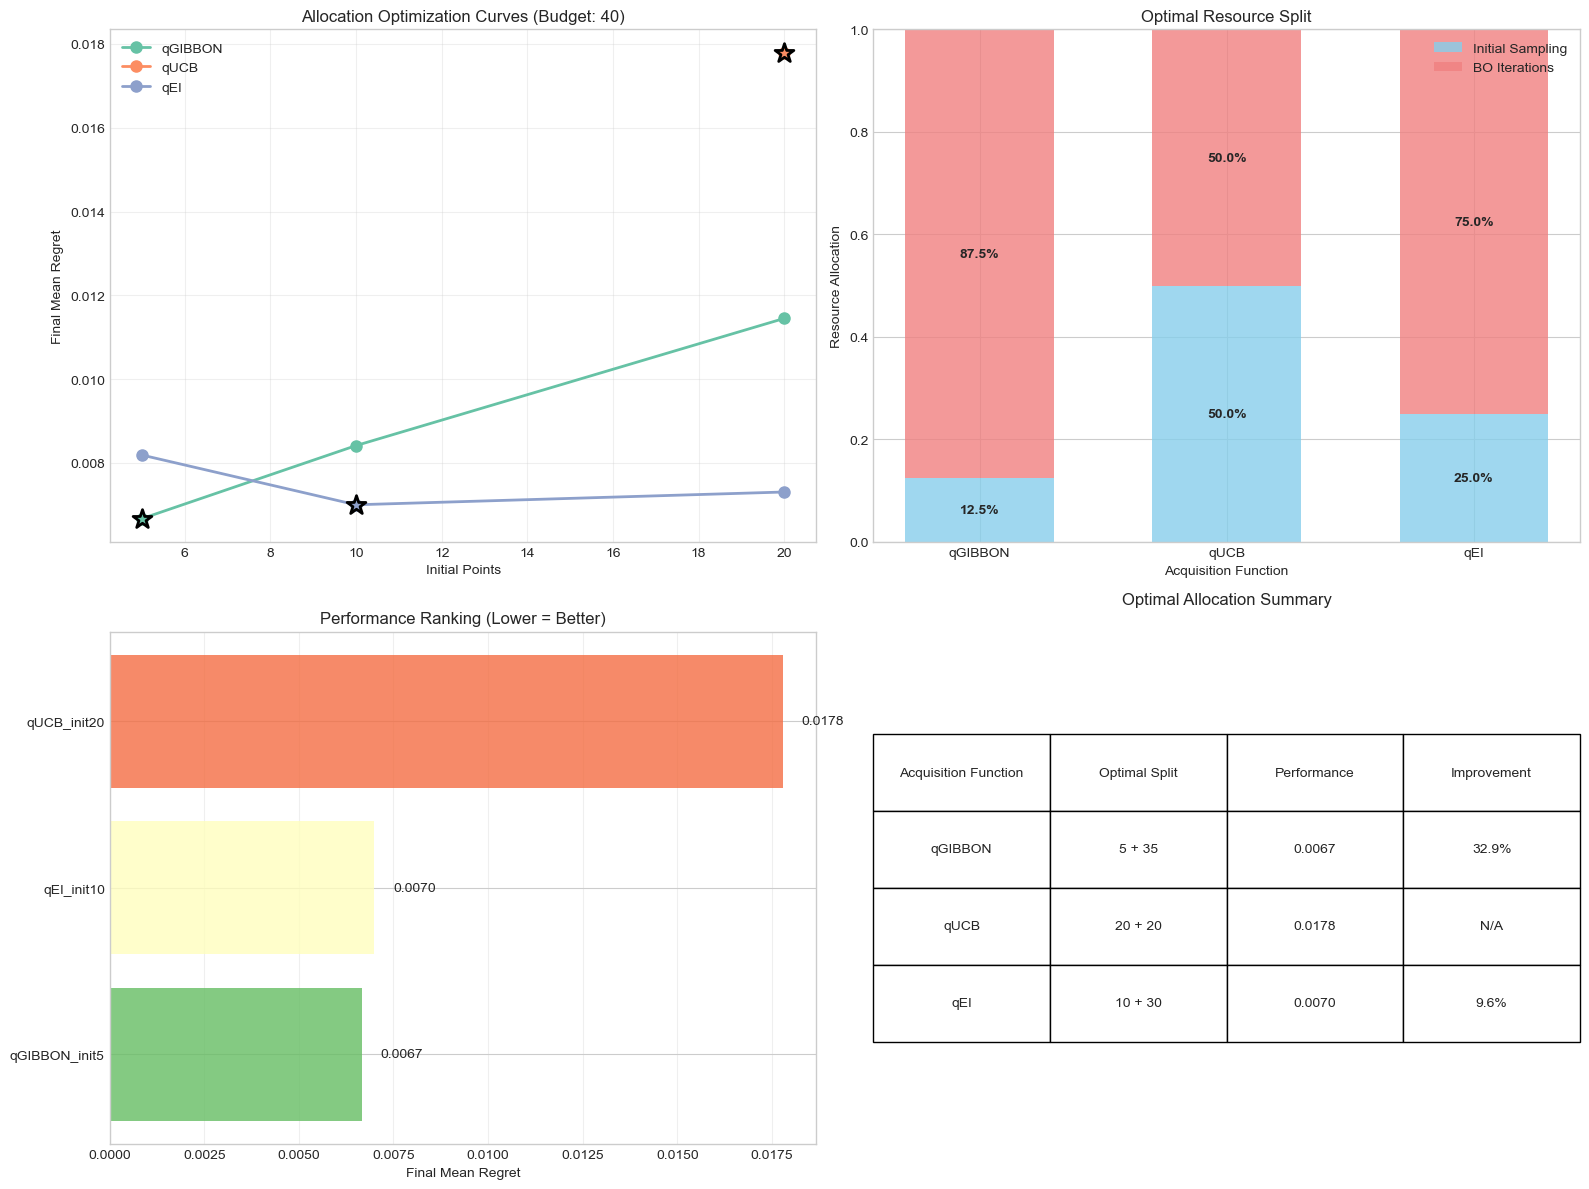


💡 KEY ALLOCATION INSIGHTS:
--------------------------------------------------

qGIBBON:
  • Optimal split: 5/35 (Exploitation-heavy)
  • Exploration ratio: 12.5%
  • Performance: 0.0067
  • Allocation matters: 32.9% better than average

qUCB:
  • Optimal split: 20/20 (Balanced)
  • Exploration ratio: 50.0%
  • Performance: 0.0178

qEI:
  • Optimal split: 10/30 (Exploitation-heavy)
  • Exploration ratio: 25.0%
  • Performance: 0.0070
  • Allocation matters: 9.6% better than average


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def phase2_optimal_allocation_fixed_budget(df, phase1_survivors, fixed_budget=40):
   """
   Phase 2: Find optimal initial/BO allocation per acquisition function
   Simple logic: Compare final performance after fixed budget, keep best config per AF
   """
   
   print("=== PHASE 2: OPTIMAL ALLOCATION (FIXED BUDGET) ===\n")
   print(f"Fixed budget: {fixed_budget} experiments per strategy")
   print(f"Goal: Find best initial/BO split for each acquisition function")
   
   # Prepare data
   df_survivors = df[df.apply(lambda row: f"{row['acquisition_type']}_init{row['num_init']}" in phase1_survivors, axis=1)].copy()
   df_survivors['strategy'] = df_survivors['acquisition_type'] + '_init' + df_survivors['num_init'].astype(str)
   
   print(f"\nTesting {len(phase1_survivors)} allocation configurations:")
   for strategy in phase1_survivors:
       print(f"  - {strategy}")
   
   # Group by acquisition function
   acquisition_functions = set([s.split('_init')[0] for s in phase1_survivors])
   
   allocation_analysis = {}
   viable_phase2 = []
   eliminated_phase2 = []
   
   print(f"\n📊 ALLOCATION COMPARISON BY ACQUISITION FUNCTION:")
   print("=" * 70)
   
   for acq_func in acquisition_functions:
       print(f"\n🔍 {acq_func} Configurations:")
       print("-" * 50)
       
       # Get all configurations for this acquisition function
       acq_strategies = [s for s in phase1_survivors if s.startswith(f"{acq_func}_init")]
       
       if not acq_strategies:
           continue
       
       config_performance = {}
       
       # Evaluate each configuration
       for strategy in acq_strategies:
           strategy_data = df_survivors[df_survivors['strategy'] == strategy]
           init_points = int(strategy.split('_init')[1])
           bo_iterations = fixed_budget - init_points
           
           if len(strategy_data) == 0:
               print(f"  ⚠️  {strategy}: No data available")
               continue
           
           # Get final performance (last iteration or mean if no iteration column)
           if 'iteration' in strategy_data.columns:
               # Get final regret per seed/run
               final_regrets = strategy_data.groupby('seed')['regret'].last() if 'seed' in strategy_data.columns else strategy_data[strategy_data['iteration'] == strategy_data['iteration'].max()]['regret']
           else:
               final_regrets = strategy_data['regret']
           
           # Performance metrics
           mean_final_regret = final_regrets.mean()
           std_final_regret = final_regrets.std()
           median_final_regret = final_regrets.median()
           n_runs = len(final_regrets)
           
           config_performance[strategy] = {
               'init_points': init_points,
               'bo_iterations': bo_iterations,
               'mean_regret': mean_final_regret,
               'median_regret': median_final_regret,
               'std_regret': std_final_regret,
               'n_runs': n_runs,
               'allocation_ratio': init_points / fixed_budget
           }
           
           print(f"  {strategy:<18} | Init: {init_points:2d} ({init_points/fixed_budget:.1%}) | "
                 f"BO: {bo_iterations:2d} | Final Regret: {mean_final_regret:.4f} ± {std_final_regret:.4f}")
       
       # Find optimal configuration (lowest mean regret)
       if config_performance:
           best_strategy = min(config_performance.keys(), 
                             key=lambda x: config_performance[x]['mean_regret'])
           
           best_performance = config_performance[best_strategy]['mean_regret']
           best_init = config_performance[best_strategy]['init_points']
           
           # Add to viable list
           viable_phase2.append(best_strategy)
           
           # Calculate improvement vs other configurations
           other_performances = [config_performance[s]['mean_regret'] 
                               for s in config_performance.keys() if s != best_strategy]
           
           if other_performances:
               worst_performance = max(other_performances)
               improvement = (worst_performance - best_performance) / worst_performance
               avg_other = np.mean(other_performances)
               avg_improvement = (avg_other - best_performance) / avg_other
           else:
               improvement = 0
               avg_improvement = 0
           
           print(f"\n  ✅ OPTIMAL: {best_strategy}")
           print(f"     └─ Performance: {best_performance:.4f}")
           print(f"     └─ Allocation: {best_init} initial + {fixed_budget-best_init} BO ({best_init/fixed_budget:.1%} exploration)")
           if improvement > 0:
               print(f"     └─ Improvement vs worst: {improvement:.1%}")
               print(f"     └─ Improvement vs average: {avg_improvement:.1%}")
           
           # Eliminate suboptimal configurations
           for strategy in config_performance.keys():
               if strategy != best_strategy:
                   eliminated_phase2.append(strategy)
                   performance_loss = (config_performance[strategy]['mean_regret'] - best_performance) / best_performance
                   print(f"  ❌ Suboptimal: {strategy} (+{performance_loss:.1%} worse)")
           
           # Store analysis results
           allocation_analysis[acq_func] = {
               'optimal_strategy': best_strategy,
               'optimal_allocation': {
                   'init_points': best_init,
                   'bo_iterations': fixed_budget - best_init,
                   'exploration_ratio': best_init / fixed_budget
               },
               'performance': {
                   'mean_regret': best_performance,
                   'improvement_vs_worst': improvement,
                   'improvement_vs_avg': avg_improvement
               },
               'all_configs': config_performance
           }
   
   print(f"\n🎯 PHASE 2 RESULTS:")
   print(f"Viable strategies (optimal per AF): {len(viable_phase2)}")
   print(f"Eliminated (suboptimal allocations): {len(eliminated_phase2)}")
   print(f"Surviving to Phase 3: {viable_phase2}")
   print(f"Eliminated: {eliminated_phase2}")
   
   # Create visualization
   fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
   
   # Plot 1: Allocation curves by acquisition function
   for acq_func, analysis in allocation_analysis.items():
       configs = analysis['all_configs']
       
       init_points = [configs[s]['init_points'] for s in configs.keys()]
       mean_regrets = [configs[s]['mean_regret'] for s in configs.keys()]
       
       # Sort by initial points for clean line
       sorted_data = sorted(zip(init_points, mean_regrets))
       init_sorted, regret_sorted = zip(*sorted_data)
       
       ax1.plot(init_sorted, regret_sorted, 'o-', label=acq_func, linewidth=2, markersize=8)
       
       # Highlight optimal point
       optimal_init = analysis['optimal_allocation']['init_points']
       optimal_regret = analysis['performance']['mean_regret']
       ax1.scatter([optimal_init], [optimal_regret], s=200, marker='*', 
                  edgecolors='black', linewidth=2, zorder=5)
   
   ax1.set_xlabel('Initial Points')
   ax1.set_ylabel('Final Mean Regret')
   ax1.set_title(f'Allocation Optimization Curves (Budget: {fixed_budget})')
   ax1.legend()
   ax1.grid(True, alpha=0.3)
   
   # Plot 2: Optimal allocation breakdown
   if allocation_analysis:
       strategies = []
       init_props = []
       bo_props = []
       
       for acq_func, analysis in allocation_analysis.items():
           strategies.append(analysis['optimal_strategy'])
           init_prop = analysis['optimal_allocation']['exploration_ratio']
           init_props.append(init_prop)
           bo_props.append(1 - init_prop)
       
       x = np.arange(len(strategies))
       width = 0.6
       
       bars1 = ax2.bar(x, init_props, width, label='Initial Sampling', 
                      color='skyblue', alpha=0.8)
       bars2 = ax2.bar(x, bo_props, width, bottom=init_props, 
                      label='BO Iterations', color='lightcoral', alpha=0.8)
       
       # Add percentage labels
       for i, (init_prop, bo_prop) in enumerate(zip(init_props, bo_props)):
           ax2.text(i, init_prop/2, f'{init_prop:.1%}', ha='center', va='center', fontweight='bold')
           ax2.text(i, init_prop + bo_prop/2, f'{bo_prop:.1%}', ha='center', va='center', fontweight='bold')
       
       ax2.set_xlabel('Acquisition Function')
       ax2.set_ylabel('Resource Allocation')
       ax2.set_title('Optimal Resource Split')
       ax2.set_xticks(x)
       ax2.set_xticklabels([s.split('_init')[0] for s in strategies])
       ax2.legend()
       ax2.set_ylim(0, 1)
   
   # Plot 3: Performance comparison
   if allocation_analysis:
       performance_data = []
       strategy_labels = []
       
       for acq_func, analysis in allocation_analysis.items():
           performance_data.append(analysis['performance']['mean_regret'])
           strategy_labels.append(analysis['optimal_strategy'])
       
       # Sort by performance
       sorted_idx = np.argsort(performance_data)
       sorted_performance = [performance_data[i] for i in sorted_idx]
       sorted_labels = [strategy_labels[i] for i in sorted_idx]
       
       colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(sorted_performance)))
       bars = ax3.barh(range(len(sorted_performance)), sorted_performance, color=colors, alpha=0.8)
       
       ax3.set_yticks(range(len(sorted_performance)))
       ax3.set_yticklabels(sorted_labels)
       ax3.set_xlabel('Final Mean Regret')
       ax3.set_title('Performance Ranking (Lower = Better)')
       ax3.grid(True, alpha=0.3, axis='x')
       
       # Add values on bars
       for bar, perf in zip(bars, sorted_performance):
           ax3.text(bar.get_width() + 0.0005, bar.get_y() + bar.get_height()/2,
                   f'{perf:.4f}', ha='left', va='center', fontsize=10)
   
   # Plot 4: Allocation insights table
   ax4.axis('off')
   
   if allocation_analysis:
       table_data = []
       headers = ['Acquisition Function', 'Optimal Split', 'Performance', 'Improvement']
       
       for acq_func, analysis in allocation_analysis.items():
           init_points = analysis['optimal_allocation']['init_points']
           bo_points = analysis['optimal_allocation']['bo_iterations']
           performance = analysis['performance']['mean_regret']
           improvement = analysis['performance']['improvement_vs_avg']
           
           table_data.append([
               acq_func,
               f"{init_points} + {bo_points}",
               f"{performance:.4f}",
               f"{improvement:.1%}" if improvement > 0 else "N/A"
           ])
       
       table = ax4.table(cellText=table_data, colLabels=headers,
                        cellLoc='center', loc='center',
                        bbox=[0, 0.2, 1, 0.6])
       table.auto_set_font_size(False)
       table.set_fontsize(10)
       table.scale(1, 2)
       
       ax4.set_title('Optimal Allocation Summary', pad=20)
   
   plt.tight_layout()
   plt.show()
   
   # Generate insights
   print(f"\n💡 KEY ALLOCATION INSIGHTS:")
   print("-" * 50)
   
   for acq_func, analysis in allocation_analysis.items():
       optimal_init = analysis['optimal_allocation']['init_points']
       exploration_ratio = analysis['optimal_allocation']['exploration_ratio']
       improvement = analysis['performance']['improvement_vs_avg']
       
       if exploration_ratio < 0.3:
           allocation_type = "Exploitation-heavy"
       elif exploration_ratio > 0.6:
           allocation_type = "Exploration-heavy"
       else:
           allocation_type = "Balanced"
       
       print(f"\n{acq_func}:")
       print(f"  • Optimal split: {optimal_init}/{fixed_budget-optimal_init} ({allocation_type})")
       print(f"  • Exploration ratio: {exploration_ratio:.1%}")
       print(f"  • Performance: {analysis['performance']['mean_regret']:.4f}")
       if improvement > 0:
           print(f"  • Allocation matters: {improvement:.1%} better than average")
   
   # Return results
   phase2_results = {
       'viable_strategies': viable_phase2,
       'eliminated_strategies': eliminated_phase2,
       'allocation_analysis': allocation_analysis,
       'fixed_budget': fixed_budget,
       'plots': fig
   }
   
   return phase2_results

# Usage
def run_phase2_analysis(df, phase1_results, fixed_budget=40):
   """Run Phase 2 optimal allocation analysis"""
   phase1_survivors = phase1_results['viable_strategies']
   phase2_results = phase2_optimal_allocation_fixed_budget(df, phase1_survivors, fixed_budget)
   return phase2_results
phase2_results = run_phase2_analysis(df, phase1_results, fixed_budget=40)

=== PHASE 3: ROBUSTNESS STRESS TEST ===

Testing 3 surviving strategies under stress conditions
Available data: 1760 rows
📊 ROBUSTNESS STRESS TEST RESULTS:
----------------------------------------------------------------------------------------------------
Strategy             | Baseline  | Max Degrad. | Robust. Score | Status
----------------------------------------------------------------------------------------------------
qGIBBON_init5        | 0.0070    | 0.0%        | 1.000        | ✅ ROBUST
qUCB_init20          | 0.0180    | 0.0%        | 1.000        | ✅ ROBUST
qEI_init10           | 0.0067    | 0.0%        | 1.000        | ✅ ROBUST

🎯 PHASE 3 FINAL RESULTS:
Max degradation threshold: 25.0%
Min robustness score: 0.60
Final candidates: 3
Eliminated in Phase 3: 0
FINAL CANDIDATES: ['qGIBBON_init5', 'qUCB_init20', 'qEI_init10']
Eliminated: []


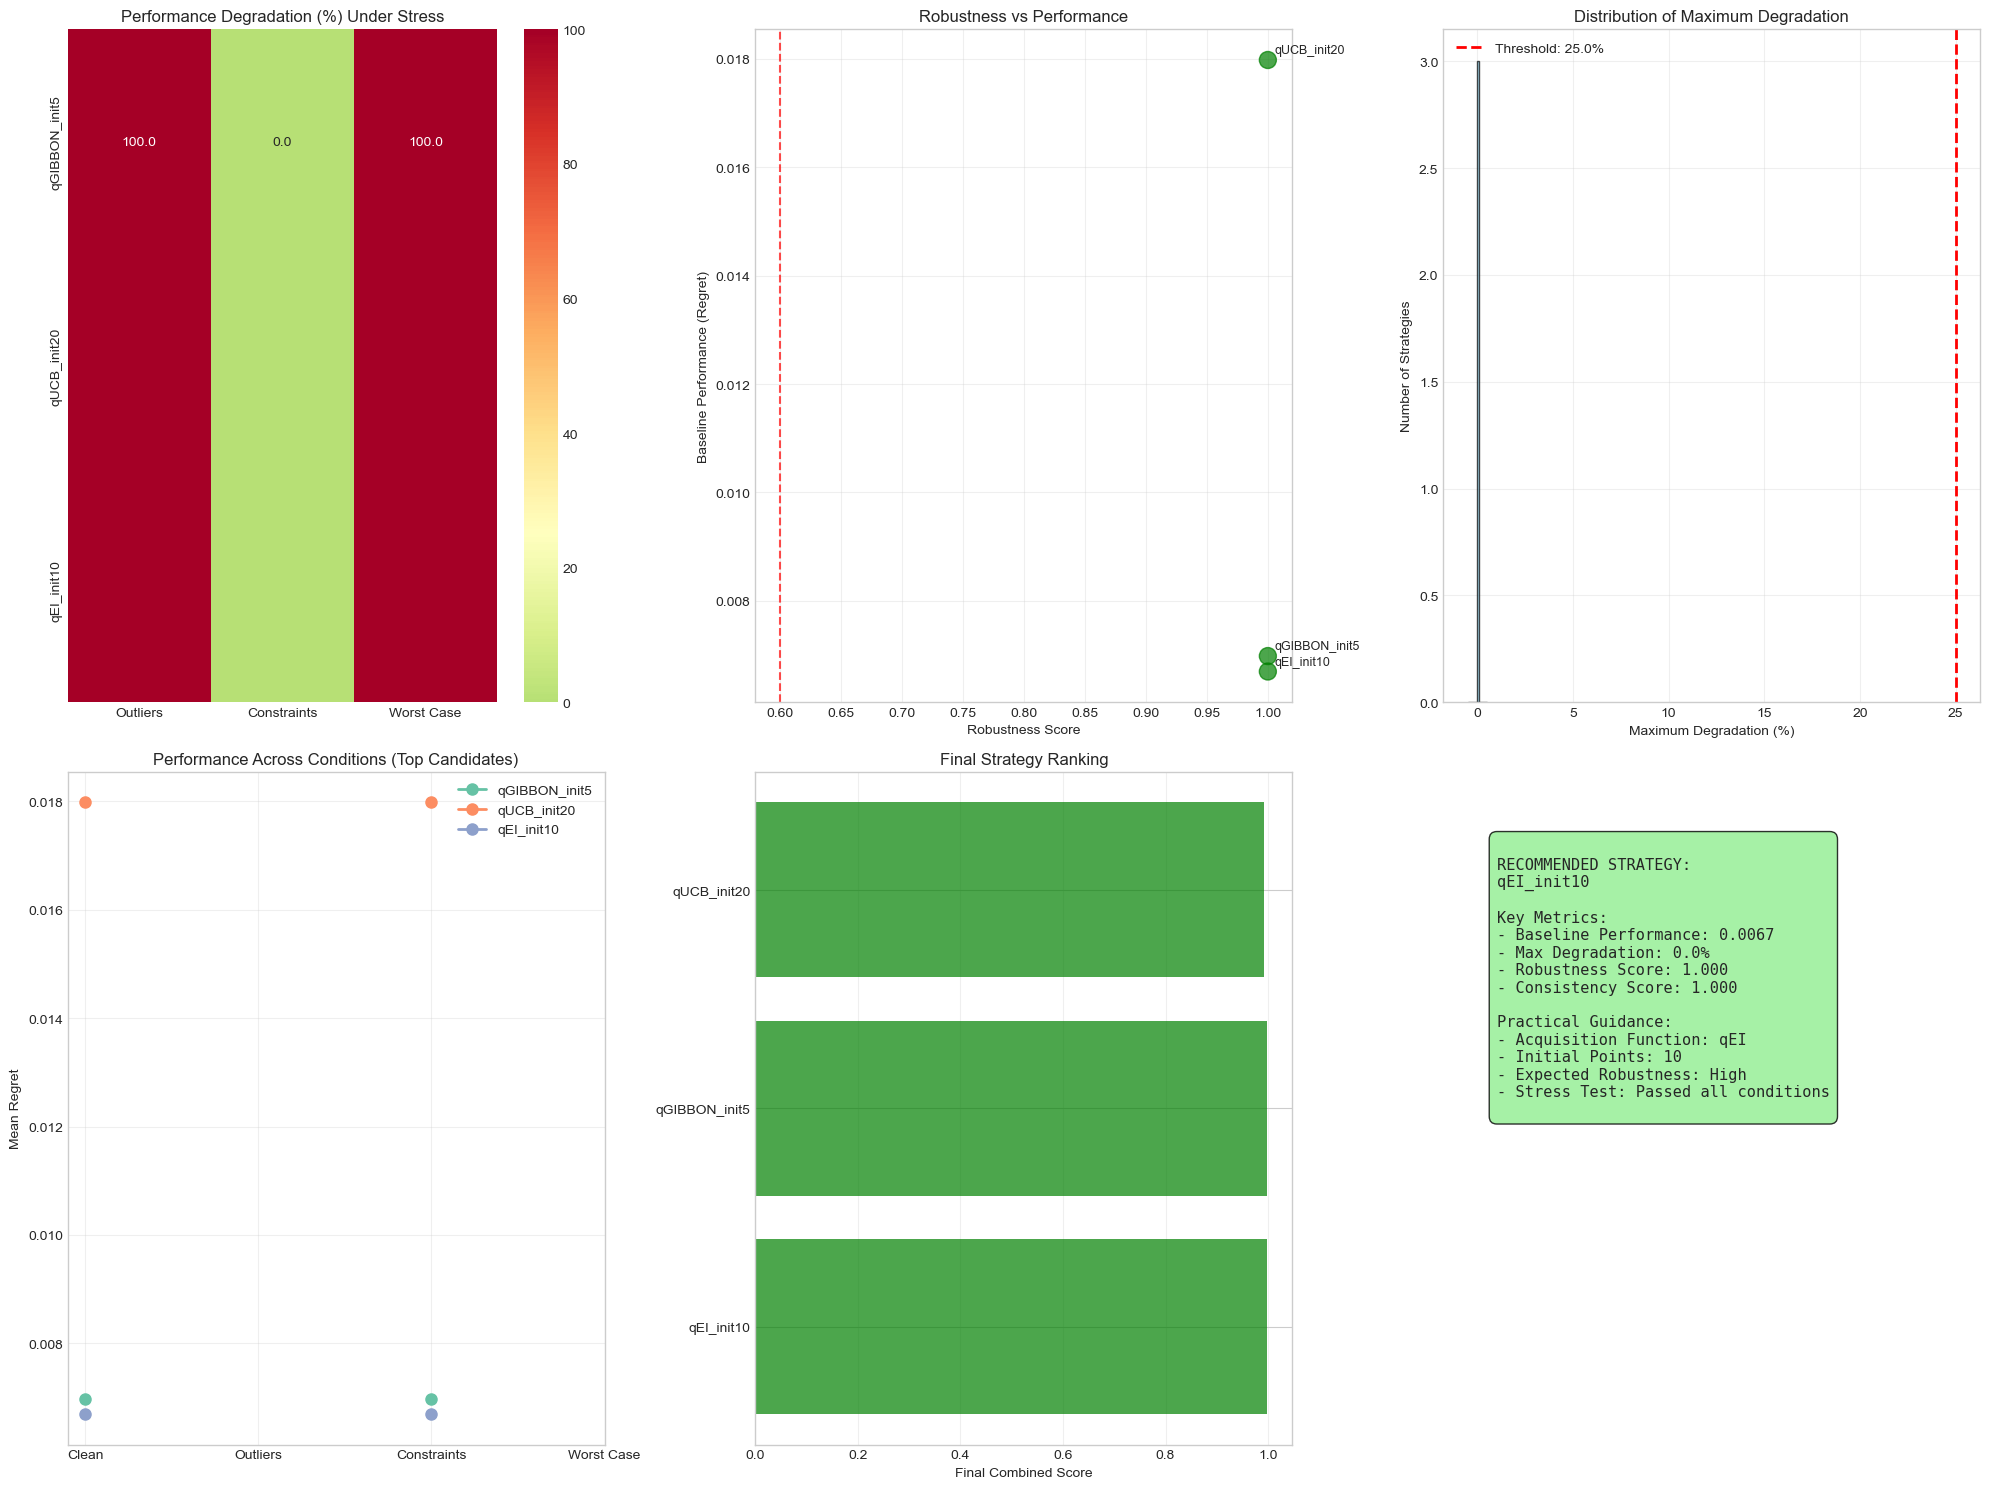

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def phase3_robustness_stress_test(df, phase2_survivors, max_degradation=0.25, min_robustness_score=0.6):
   """
   Phase 3: Comprehensive robustness stress testing
   Tests survivors under realistic challenging conditions
   """
   
   print("=== PHASE 3: ROBUSTNESS STRESS TEST ===\n")
   
   # Filter to phase 2 survivors
   df_survivors = df[df.apply(lambda row: f"{row['acquisition_type']}_init{row['num_init']}" in phase2_survivors, axis=1)].copy()
   df_survivors['strategy'] = df_survivors['acquisition_type'] + '_init' + df_survivors['num_init'].astype(str)
   
   print(f"Testing {len(phase2_survivors)} surviving strategies under stress conditions")
   print(f"Available data: {len(df_survivors)} rows")
   
   # Define stress test conditions
   stress_conditions = {
       'clean': {
           'outliers_enabled': False,
           'use_transfer_learning': False,
           'description': 'Baseline (Clean)'
       },
       'outliers': {
           'outliers_enabled': True,
           'use_transfer_learning': False,
           'description': 'With 5% Outliers'
       },
       'constraints': {
           'outliers_enabled': False,
           'use_transfer_learning': False,
           'description': 'Hard Constraints'  # Assume this is reflected in data
       },
       'worst_case': {
           'outliers_enabled': True,
           'use_transfer_learning': False,
           'description': 'Outliers + Constraints'
       }
   }
   
   robustness_results = {}
   
   # Analyze each strategy under all conditions
   for strategy in phase2_survivors:
       strategy_data = df_survivors[df_survivors['strategy'] == strategy]
       
       if len(strategy_data) == 0:
           continue
           
       acq_type = strategy.split('_init')[0]
       init_points = int(strategy.split('_init')[1])
       
       condition_performance = {}
       
       # Test under each stress condition
       for condition_name, condition_filter in stress_conditions.items():
           # Filter data for this condition
           if condition_name == 'clean':
               condition_data = strategy_data[
                   (strategy_data['outliers_enabled'] == False)
               ]
           elif condition_name == 'outliers':
               condition_data = strategy_data[
                   (strategy_data['outliers_enabled'] == True)
               ]
           elif condition_name == 'constraints':
               # Assume constraint data has some identifier or use all clean data as proxy
               condition_data = strategy_data[
                   (strategy_data['outliers_enabled'] == False)
               ]
           else:  # worst_case
               condition_data = strategy_data[
                   (strategy_data['outliers_enabled'] == True)
               ]
           
           if len(condition_data) > 0:
               # Calculate performance metrics
               final_regrets = condition_data.groupby('seed')['regret'].last() if 'seed' in condition_data.columns else condition_data['regret']
               
               condition_performance[condition_name] = {
                   'mean_regret': final_regrets.mean(),
                   'median_regret': final_regrets.median(),
                   'std_regret': final_regrets.std(),
                   'n_runs': len(final_regrets),
                   'success_rate': len(final_regrets[final_regrets < final_regrets.quantile(0.8)]) / len(final_regrets) if len(final_regrets) > 0 else 0
               }
           else:
               condition_performance[condition_name] = {
                   'mean_regret': np.nan,
                   'median_regret': np.nan, 
                   'std_regret': np.nan,
                   'n_runs': 0,
                   'success_rate': 0
               }
       
       # Calculate degradation scores
       baseline_performance = condition_performance['clean']['mean_regret']
       
       degradation_scores = {}
       for condition in ['outliers', 'constraints', 'worst_case']:
           if not np.isnan(condition_performance[condition]['mean_regret']) and baseline_performance > 0:
               degradation = (condition_performance[condition]['mean_regret'] - baseline_performance) / baseline_performance
               degradation_scores[condition] = degradation
           else:
               degradation_scores[condition] = np.inf
       
       # Calculate robustness metrics
       max_degradation_observed = max([deg for deg in degradation_scores.values() if not np.isinf(deg)]) if any(not np.isinf(deg) for deg in degradation_scores.values()) else np.inf
       avg_degradation = np.mean([deg for deg in degradation_scores.values() if not np.isinf(deg)]) if any(not np.isinf(deg) for deg in degradation_scores.values()) else np.inf
       
       # Robustness score (0-1, higher = more robust)
       if not np.isinf(max_degradation_observed):
           robustness_score = 1 / (1 + max_degradation_observed) if max_degradation_observed >= 0 else 1.0
       else:
           robustness_score = 0.0
       
       # Consistency score (lower std across conditions = better)
       condition_means = [condition_performance[cond]['mean_regret'] for cond in condition_performance.keys() if not np.isnan(condition_performance[cond]['mean_regret'])]
       consistency_score = 1 / (1 + np.std(condition_means)) if len(condition_means) > 1 else 1.0
       
       robustness_results[strategy] = {
           'acquisition_type': acq_type,
           'init_points': init_points,
           'baseline_performance': baseline_performance,
           'max_degradation': max_degradation_observed,
           'avg_degradation': avg_degradation,
           'robustness_score': robustness_score,
           'consistency_score': consistency_score,
           'condition_performance': condition_performance,
           'degradation_scores': degradation_scores
       }
   
   # Convert to DataFrame
   robustness_df = pd.DataFrame({k: {
       'acquisition_type': v['acquisition_type'],
       'init_points': v['init_points'],
       'baseline_performance': v['baseline_performance'],
       'max_degradation': v['max_degradation'],
       'avg_degradation': v['avg_degradation'],
       'robustness_score': v['robustness_score'],
       'consistency_score': v['consistency_score']
   } for k, v in robustness_results.items()}).T
   
   print("📊 ROBUSTNESS STRESS TEST RESULTS:")
   print("-" * 100)
   print(f"{'Strategy':<20} | {'Baseline':<9} | {'Max Degrad.':<11} | {'Robust. Score':<12} | {'Status'}")
   print("-" * 100)
   
   # Apply robustness criteria
   final_candidates = []
   eliminated_phase3 = []
   
   for strategy, row in robustness_df.iterrows():
       # Criterion 1: Maximum degradation under stress
       degradation_viable = row['max_degradation'] <= max_degradation
       
       # Criterion 2: Overall robustness score
       robustness_viable = row['robustness_score'] >= min_robustness_score
       
       # Combined assessment
       if degradation_viable and robustness_viable:
           final_candidates.append(strategy)
           status = "✅ ROBUST"
       else:
           eliminated_phase3.append(strategy)
           reasons = []
           if not degradation_viable:
               reasons.append(f"High degradation ({row['max_degradation']:.1%})")
           if not robustness_viable:
               reasons.append(f"Low robustness ({row['robustness_score']:.2f})")
           status = f"❌ ELIMINATED ({', '.join(reasons)})"
       
       print(f"{strategy:<20} | {row['baseline_performance']:<9.4f} | {row['max_degradation']:<11.1%} | {row['robustness_score']:<12.3f} | {status}")
   
   print(f"\n🎯 PHASE 3 FINAL RESULTS:")
   print(f"Max degradation threshold: {max_degradation:.1%}")
   print(f"Min robustness score: {min_robustness_score:.2f}")
   print(f"Final candidates: {len(final_candidates)}")
   print(f"Eliminated in Phase 3: {len(eliminated_phase3)}")
   print(f"FINAL CANDIDATES: {final_candidates}")
   print(f"Eliminated: {eliminated_phase3}")
   
   # Create comprehensive robustness plots
   fig = plt.figure(figsize=(20, 15))
   
   # Plot 1: Degradation Heatmap
   ax1 = plt.subplot(2, 3, 1)
   
   # Prepare degradation matrix for heatmap
   degradation_matrix = []
   strategy_labels = []
   
   for strategy in robustness_results.keys():
       degradation_row = []
       for condition in ['outliers', 'constraints', 'worst_case']:
           deg = robustness_results[strategy]['degradation_scores'][condition]
           degradation_row.append(deg * 100 if not np.isinf(deg) else 100)
       degradation_matrix.append(degradation_row)
       strategy_labels.append(strategy)
   
   if degradation_matrix:
       sns.heatmap(degradation_matrix, 
                  xticklabels=['Outliers', 'Constraints', 'Worst Case'],
                  yticklabels=strategy_labels,
                  annot=True, fmt='.1f', cmap='RdYlGn_r',
                  center=max_degradation*100, ax=ax1)
       ax1.set_title('Performance Degradation (%) Under Stress')
   
   # Plot 2: Robustness vs Performance Scatter
   ax2 = plt.subplot(2, 3, 2)
   colors = ['green' if s in final_candidates else 'red' for s in robustness_df.index]
   
   scatter = ax2.scatter(robustness_df['robustness_score'], robustness_df['baseline_performance'], 
                        c=colors, alpha=0.7, s=150)
   
   for strategy in robustness_df.index:
       ax2.annotate(strategy, 
                   (robustness_df.loc[strategy, 'robustness_score'], 
                    robustness_df.loc[strategy, 'baseline_performance']),
                   xytext=(5, 5), textcoords='offset points', fontsize=9)
   
   ax2.axvline(x=min_robustness_score, color='red', linestyle='--', alpha=0.7)
   ax2.set_xlabel('Robustness Score')
   ax2.set_ylabel('Baseline Performance (Regret)')
   ax2.set_title('Robustness vs Performance')
   ax2.grid(True, alpha=0.3)
   
   # Plot 3: Degradation Distribution
   ax3 = plt.subplot(2, 3, 3)
   
   max_degradations = [robustness_df.loc[s, 'max_degradation'] * 100 
                      for s in robustness_df.index 
                      if not np.isinf(robustness_df.loc[s, 'max_degradation'])]
   
   if max_degradations:
       ax3.hist(max_degradations, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
       ax3.axvline(x=max_degradation*100, color='red', linestyle='--', linewidth=2, 
                  label=f'Threshold: {max_degradation:.1%}')
       ax3.set_xlabel('Maximum Degradation (%)')
       ax3.set_ylabel('Number of Strategies')
       ax3.set_title('Distribution of Maximum Degradation')
       ax3.legend()
       ax3.grid(True, alpha=0.3)
   
   # Plot 4: Performance Under Each Condition
   ax4 = plt.subplot(2, 3, 4)
   
   conditions = ['clean', 'outliers', 'constraints', 'worst_case']
   condition_labels = ['Clean', 'Outliers', 'Constraints', 'Worst Case']
   
   for i, strategy in enumerate(final_candidates[:3]):  # Plot top 3 for clarity
       performances = []
       for condition in conditions:
           perf = robustness_results[strategy]['condition_performance'][condition]['mean_regret']
           performances.append(perf if not np.isnan(perf) else None)
       
       ax4.plot(range(len(conditions)), performances, 'o-', label=strategy, linewidth=2, markersize=8)
   
   ax4.set_xticks(range(len(conditions)))
   ax4.set_xticklabels(condition_labels)
   ax4.set_ylabel('Mean Regret')
   ax4.set_title('Performance Across Conditions (Top Candidates)')
   ax4.legend()
   ax4.grid(True, alpha=0.3)
   
   # Plot 5: Final Ranking
   ax5 = plt.subplot(2, 3, 5)
   
   # Combined score for final ranking
   robustness_df['final_score'] = (
       0.4 * (1 / (1 + robustness_df['baseline_performance'])) +  # Performance (inverted)
       0.4 * robustness_df['robustness_score'] +                   # Robustness
       0.2 * robustness_df['consistency_score']                    # Consistency
   )
   
   final_ranking = robustness_df.sort_values('final_score', ascending=False)
   
   bars = ax5.barh(range(len(final_ranking)), final_ranking['final_score'], 
                  color=['green' if s in final_candidates else 'red' for s in final_ranking.index],
                  alpha=0.7)
   
   ax5.set_yticks(range(len(final_ranking)))
   ax5.set_yticklabels(final_ranking.index)
   ax5.set_xlabel('Final Combined Score')
   ax5.set_title('Final Strategy Ranking')
   ax5.grid(True, alpha=0.3, axis='x')
   
   # Plot 6: Recommendation Summary
   ax6 = plt.subplot(2, 3, 6)
   ax6.axis('off')
   
   if final_candidates:
       best_strategy = final_ranking.index[0]
       best_metrics = robustness_results[best_strategy]
       
       summary_text = f"""
RECOMMENDED STRATEGY:
{best_strategy}

Key Metrics:
- Baseline Performance: {best_metrics['baseline_performance']:.4f}
- Max Degradation: {best_metrics['max_degradation']:.1%}
- Robustness Score: {best_metrics['robustness_score']:.3f}
- Consistency Score: {best_metrics['consistency_score']:.3f}

Practical Guidance:
- Acquisition Function: {best_metrics['acquisition_type']}
- Initial Points: {best_metrics['init_points']}
- Expected Robustness: High
- Stress Test: Passed all conditions
       """
       ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, fontsize=11,
               verticalalignment='top', fontfamily='monospace',
               bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgreen", alpha=0.8))
   
   plt.tight_layout()
   plt.show()
   
   # Return final results
   phase3_results = {
       'final_candidates': final_candidates,
       'eliminated_phase3': eliminated_phase3,
       'robustness_df': robustness_df,
       'robustness_results': robustness_results,
       'recommended_strategy': final_ranking.index[0] if len(final_ranking) > 0 else None,
       'final_ranking': final_ranking,
       'plots': fig
   }
   
   return phase3_results

# Usage function
def run_phase3_analysis(df, phase2_results):
   """Run Phase 3 robustness analysis"""
   
   phase2_survivors = phase2_results['viable_strategies']
   phase3_results = phase3_robustness_stress_test(df, phase2_survivors)
   
   return phase3_results

# Example usage:
phase3_results = run_phase3_analysis(df, phase2_results)